In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
dat = pd.read_excel("data/NanoNASCseq_Summary.xlsx")
dat.index = dat["Cell"]

--------------------------------------------------------------------------------
Cell line: K562
Cells: 190


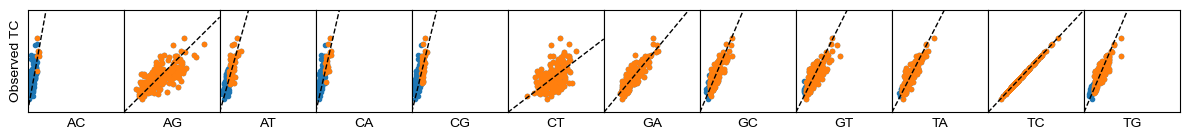

   Type         K         R
0    AC  5.185097  0.114779
1    AG  0.929604  0.709538
2    AT  3.320838  0.637090
3    CA  4.053154  0.595337
4    CG  3.830236  0.581274
5    CT  0.716909  0.530177
6    GA  1.128502  0.869176
7    GC  2.202353  0.823068
8    GT  1.870887  0.812051
9    TA  1.829628  0.887367
10   TC  1.000000  1.000000
11   TG  2.199223  0.846579
Model:
   Type         K         R         W
6    GA  1.128502  0.869176  0.205079
7    GC  2.202353  0.823068  0.194200
8    GT  1.870887  0.812051  0.191601
9    TA  1.829628  0.887367  0.209372
11   TG  2.199223  0.846579  0.199748
Custom strategy:
K: 1.0050, R: 0.9321


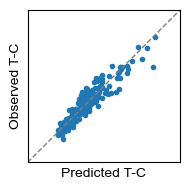

NASC-seq strategy:
K: 0.8715, R: 0.7776


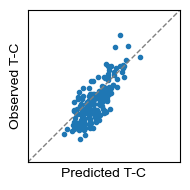

GRAND-SLAM strategy:
K: 2.0266, R: 0.9075


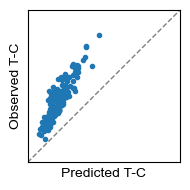

--------------------------------------------------------------------------------
Cell line: mESC
Cells: 64


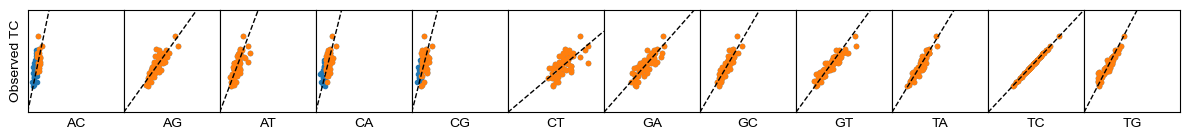

   Type         K         R
0    AC  4.456653  0.233286
1    AG  1.312608  0.814678
2    AT  2.489507  0.703368
3    CA  3.710027  0.465096
4    CG  3.697851  0.321909
5    CT  0.792507  0.647563
6    GA  1.061507  0.831894
7    GC  1.607250  0.873314
8    GT  1.286485  0.921665
9    TA  1.542539  0.939190
10   TC  1.000000  1.000000
11   TG  1.806083  0.947229
Model:
   Type         K         R         W
1    AG  1.312608  0.814678  0.152906
6    GA  1.061507  0.831894  0.156137
7    GC  1.607250  0.873314  0.163911
8    GT  1.286485  0.921665  0.172986
9    TA  1.542539  0.939190  0.176275
11   TG  1.806083  0.947229  0.177784
Custom strategy:
K: 0.9972, R: 0.9418


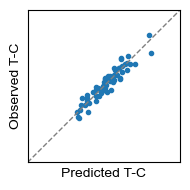

NASC-seq strategy:
K: 0.9050, R: 0.8153


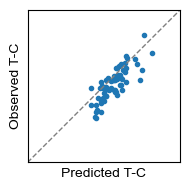

GRAND-SLAM strategy:
K: 1.6622, R: 0.9566


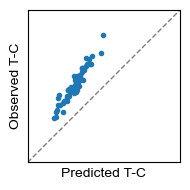

In [16]:
for cell_line in ["K562", "mESC"]:  
    print("-" * 80)
    print("Cell line:", cell_line)
    d = dat[(dat["CellLine"] == cell_line) & (dat["s4U"] == 0) & (dat["Time"] == 3) & (dat["ActD"].isna()) & (dat["UMIs"] >= 5000)]
    print("Cells:", len(d))

    array = []
    for run, cell in d[["Run", "Cell"]].values:
        path = "results/mismatch/ratio_consensus/%s/%s.tsv" % (run, cell)
        s = pd.read_csv(path, sep="\t", index_col=0)["Ratio"]
        s.name = cell
        array.append(s)
    m = pd.DataFrame(array)
    m.index.name = "Cell"

    mtypes = []
    bases = "ACGT"
    for b1 in "ACGT":
        for b2 in "ACGT":
            if b1 != b2:
                mtypes.append("%s%s" % (b1, b2))

    lim = m.max().max() * 1.2
    fig, axs = plt.subplots(1, 12, figsize=(12, 1.5), sharex=True, sharey=True, gridspec_kw=dict(wspace=0))
    rows = []
    for i, mtype in enumerate(mtypes):
        ax = axs[i]
        plt.sca(ax)
        xs = m[mtype]
        ys = m["TC"]
        flags = (xs > lim * 0.1) & (ys > lim * 0.1)
        xs1 = xs[flags]
        ys1 = ys[flags]
        r = np.corrcoef(xs1, ys1)[0][1]
        k = np.e ** ((sum(np.log(ys1)) - sum(np.log(xs1))) / len(xs1))
        rows.append([mtype, k, r])
        plt.scatter(xs, ys, marker=".")
        plt.scatter(xs1, ys1, marker=".")
        plt.plot([0, lim], [0, lim * k], lw=1, ls="--", color="black")
        plt.xlim(0, lim)
        plt.ylim(0, lim)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(mtype)
        if i == 0:
            plt.ylabel("Observed TC")
    plt.tight_layout()
    plt.show()
    plt.close()

    model = pd.DataFrame(rows, columns=["Type", "K", "R"])
    print(model)
    model = model[(model["Type"] != "TC") & (model["R"] >= 0.8)]
    model["W"] = model["R"] / model["R"].sum()
    model.to_csv("reports/Estimate.Pe.Model.consensus.%s.tsv" % cell_line, sep="\t", index=False)
    print("Model:")
    print(model)

    array = []
    for t, k, r, w in model.values:
        array.append(m[t] * k * w)
    m1 = m.copy()
    m1["Pe"] = pd.DataFrame(array).sum(axis=0)

    params = [
        ["Custom", m1["Pe"], m1["TC"]],
        ["NASC-seq", (m1["CT"] + m1["GA"]) / 2, m1["TC"]],
        ["GRAND-SLAM",(m1["TA"] + m1["TG"]) / 2, m1["TC"]],
    ]
    for name, xs, ys in params:
        print("%s strategy:" % name)
        lim = max(max(xs), max(ys)) * 1.2
        r = np.corrcoef(xs, ys)[0][1]
        k = np.e ** ((sum(np.log(ys)) - sum(np.log(xs))) / len(xs))
        print("K: %.4f, R: %.4f" % (k, r))
        plt.figure(figsize=(2, 2))
        plt.scatter(xs, ys, marker=".")
        plt.plot([0, lim], [0, lim], lw=1, ls="--", color="grey")
        plt.xlim(0, lim)
        plt.ylim(0, lim)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Predicted T-C")
        plt.ylabel("Observed T-C")
        plt.tight_layout()
        plt.show()
        plt.close()